In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

2024-03-16 12:16:13.799039: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Read in the Data

For this activity, we will use the data from the Herbarium Challenge described in [Little et al. (2020)](https://bsapubs.onlinelibrary.wiley.com/doi/pdf/10.1002/aps3.11365).

The data are a set of images of herbarium specimens labeled by species.

The training data consists of 34225 images and labels. The labels indicate to which of 683 species the imaged specimens belong. The validation data consists of 2679 images and labels.

In the interest of time, we will only consider the five species with the mostimages. So, our training data will consist of 2575 images and labels and our validation data will consist of 174 images and labels.

We will not use testing data here, because the authors did not provide the labels. Imagine that the authors will evaluate your model on the testing data once you turn a finalized model over to them.

In [5]:
# Step 1: Define parameters
batch_size = 32
image_height = 150
image_width = 150
num_classes = 5

# Step 2: Define data preprocessing function
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [image_height, image_width])
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return image, label

# Step 3: Load and preprocess the training dataset
train_data_dir = 'cnn_data/small-train/'

train_image_paths = []
train_labels = []
label_count = {}  # Dictionary to store the count of images for each label

train_categories = os.listdir(train_data_dir)
for category in train_categories:
    category_path = os.path.join(train_data_dir, category)
    if os.path.isdir(category_path):
        label = int(category)
        image_files = os.listdir(category_path)
        label_count[label] = len(image_files)  # Count the number of images for this label
        for image_file in image_files:
            image_path = os.path.join(category_path, image_file)
            train_image_paths.append(image_path)
            train_labels.append(label)

# Select the top n classes with the largest number of training images
sorted_labels = sorted(label_count.items(), key=lambda x: x[1], reverse=True)
top_labels = [label for label, _ in sorted_labels[:num_classes]]

# Filter the training dataset to include only the top n classes
filtered_train_image_paths = []
filtered_train_labels = []
for image_path, label in zip(train_image_paths, train_labels):
    if label in top_labels:
        filtered_train_image_paths.append(image_path)
        filtered_train_labels.append(label)

# Create a mapping from original labels to new labels (continuous integers starting from 0)
label_mapping = {label: idx for idx, label in enumerate(top_labels)}

# Map the original labels to new labels in the training dataset
mapped_train_labels = [label_mapping[label] for label in filtered_train_labels]

# Create TensorFlow Dataset for training
train_dataset = tf.data.Dataset.from_tensor_slices((filtered_train_image_paths, mapped_train_labels))
train_dataset = train_dataset.map(preprocess_image)
train_dataset = train_dataset.shuffle(buffer_size=len(filtered_train_image_paths)).batch(batch_size)

# Step 4: Load and preprocess the validation dataset
val_data_dir = 'cnn_data/small-validation/'

val_image_paths = []
val_labels = []

val_categories = os.listdir(val_data_dir)
for category in val_categories:
    category_path = os.path.join(val_data_dir, category)
    if os.path.isdir(category_path):
        label = int(category)
        if label in top_labels:
            image_files = os.listdir(category_path)
            for image_file in image_files:
                image_path = os.path.join(category_path, image_file)
                val_image_paths.append(image_path)
                val_labels.append(label)

# Map the original labels to new labels in the validation dataset
mapped_val_labels = [label_mapping[label] for label in val_labels]

# Create TensorFlow Dataset for validation data
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, mapped_val_labels))
val_dataset = val_dataset.map(preprocess_image)
val_dataset = val_dataset.batch(batch_size)

# print size of datasets
print('Validation set: %s' % len(val_labels))
print('Training set: %s' % len(filtered_train_labels))
print("Range of labels in train_labels:", min(mapped_train_labels), "to", max(mapped_train_labels))


Validation set: 174
Training set: 2575
Range of labels in train_labels: 0 to 4


# Look at some images

We will view a fiew images from the training dataset.

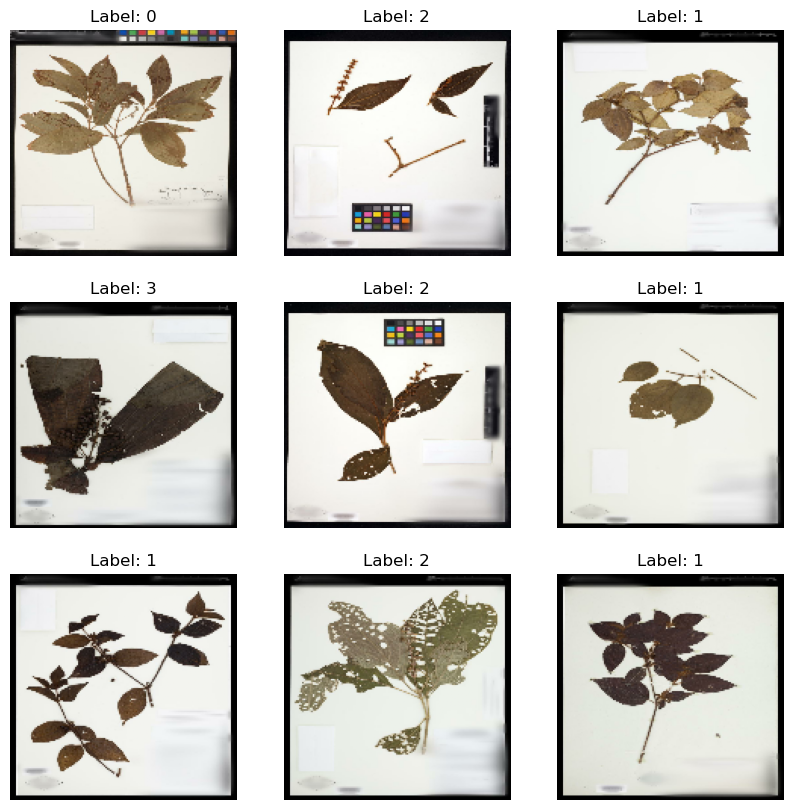

In [6]:
# Step 3: Display some example images
for images, labels in train_dataset.take(1):  # Take 1 batch as an example
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Display 9 example images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()

# Build and train the CNN

Below we define and train a CNN. We evaluate accuracy on a training and validation dataset.

Epoch 1/5
81/81 [==============================] - 25s 289ms/step - loss: 1.5074 - accuracy: 0.3200 - val_loss: 1.3123 - val_accuracy: 0.4540
Epoch 2/5
81/81 [==============================] - 25s 291ms/step - loss: 1.1520 - accuracy: 0.5313 - val_loss: 1.0482 - val_accuracy: 0.5287
Epoch 3/5
81/81 [==============================] - 30s 352ms/step - loss: 0.9075 - accuracy: 0.6377 - val_loss: 0.8520 - val_accuracy: 0.5862
Epoch 4/5
81/81 [==============================] - 31s 356ms/step - loss: 0.7523 - accuracy: 0.6955 - val_loss: 0.7291 - val_accuracy: 0.6437
Epoch 5/5
81/81 [==============================] - 30s 344ms/step - loss: 0.6241 - accuracy: 0.7522 - val_loss: 0.7585 - val_accuracy: 0.6667


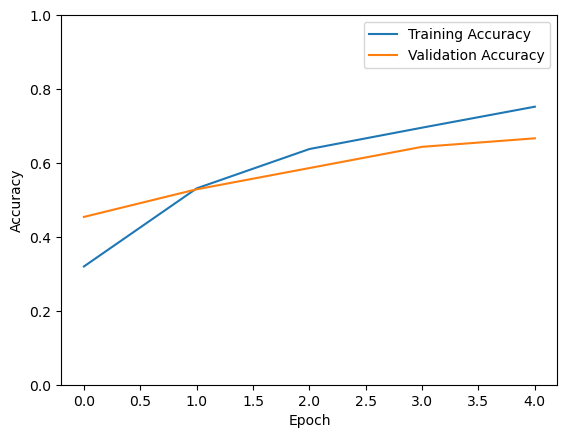

In [14]:
# Step 3: Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(18, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes)
])

# Step 5: Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Step 6: Train the model with validation data
history = model.fit(train_dataset, epochs=5, validation_data=val_dataset)

# Step 7: Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.legend()
plt.show()

# 6990 Only
Add code to create confusion matrices for your validation and training data. Look back at the FCNN activity for help.